<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 1.1 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re 
import seaborn as sns
import warnings

from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from pymystem3 import Mystem
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

warnings.filterwarnings("ignore")
%matplotlib inline

nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Загрузим датасет и посмотрим на данные с помощью методов **.sample()** и **.info()**:

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
display(data.sample(10))
display(data.info())

,text,toxic
28320,"""\n\nimprovements of the article\nBBC has remo...",0
48250,"""\n There are other ways to source besides poi...",0
41978,My point wasn't you commenting about me applyi...,0
56533,"""\nTrue, but you did help. ) - • Talk • Coor....",0
123762,"""\n\nI reluctantly consult a copy of the 4th e...",0
18974,"Motorsport infobox \n\nOK, I agree with what y...",0
14072,"""\n\nHandle in text: It is not clear exactly ...",0
128694,YOU ARE A NO GOOD PHONEY\n\nALL YOUR ARTICLES ...,1
105577,""" (UTC)\n\nI am going to partly undo the edit....",0
127849,Template:Infobox very fit for this section.\n ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Пропусков нет, однако, тексты комментариев нуждаются в предобработке.  

Для начала с помощью регулярных выражений очистим тексты от ненужных символов:

In [5]:
def clear_text(row):
    cleared_text = re.sub(r'[^a-zA-Z ]', ' ', row['text'])
    return cleared_text

data['text'] = data.apply(clear_text, axis=1)

Теперь лемматизируем комментарии с помощью `WordNetLemmatizer`:

In [6]:
def lemmatize(row):
    lemmatizer = WordNetLemmatizer() 
    text_tokenized = nltk.word_tokenize(row['text'])
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text_tokenized])
    return lemmatized_text

data['text'] = data.apply(lemmatize, axis=1)

Убедимся, что преобразования прошли корректно:

In [7]:
data.sample(10)

,text,toxic
133992,Thanks Bobrayner Hope to see you around more o...,0
49903,Well it could be real have you checked It soun...,0
29088,Agree to Remove This is about credible scholar...,0
149731,The bot ha stopped again,0
138173,Fair use rationale for Image Witch Hunter Amon...,0
16603,Update Wondering if you could update this to t...,0
49805,It doe not matter if you torture and murder pe...,0
25541,If you really want to shorten thus section pro...,0
20615,You ll appreciate this a a lawyer Here is a gr...,0
30794,The refimprove tag wa for additional citation ...,0


Судя по всему, `nltk` не очень хорошо справляется с лемматизацией. Сравним с модулем `pymystem3` от Яндекса. Писать функции не будем, просто пройдем циклом по первым десяти текстам - этого будет достаточно, чтобы проверить, есть ли разница:

In [8]:
m = Mystem()

sample_corpus = list(data['text'].head(10))
cleared_corpus = []
mystem_corpus = []

for text in sample_corpus:
    cleared_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    cleared_corpus.append(cleared_text)
    
for text in cleared_corpus:
    lem_list = m.lemmatize(text)
    mystem_corpus.append(''.join(lem_list))
    

    
print(mystem_corpus)
print()
print(sample_corpus)

['Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now\n', 'D aww He match this background colour I m seemingly stuck with Thanks talk January UTC\n', 'Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info\n', 'More I can t make any real suggestion on improvement I wondered if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know There appears to

Разницы в качестве нет - с английским языком оба модуля справляются так себе.   

Теперь исключим стоп-слова и заодно приведем все к нижнему регистру:

In [9]:
stop_words = set(stopwords.words('english'))

def drop_stop_words(row):
    splitted_text = row['text'].split()
    new_text = ' '.join([word.lower() for word in splitted_text if not word in stop_words])
    return new_text

data['text'] = data.apply(drop_stop_words, axis=1)

Можно также посмотреть, какие слова употребляются наиболее часто в положительных и токсичных комментариях:

In [10]:
positive = str(list(data.loc[data['toxic'] == 0]['text']))
negative = str(list(data.loc[data['toxic'] == 1]['text']))

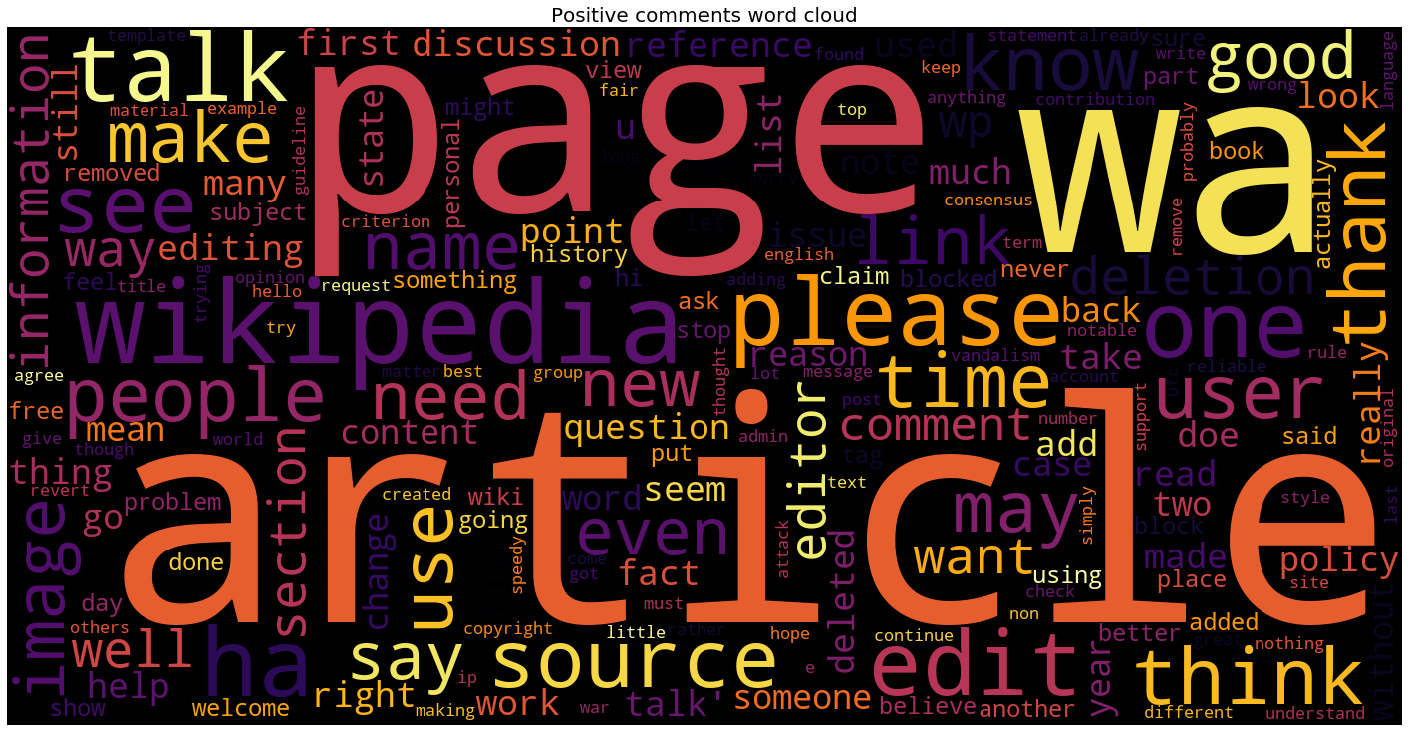

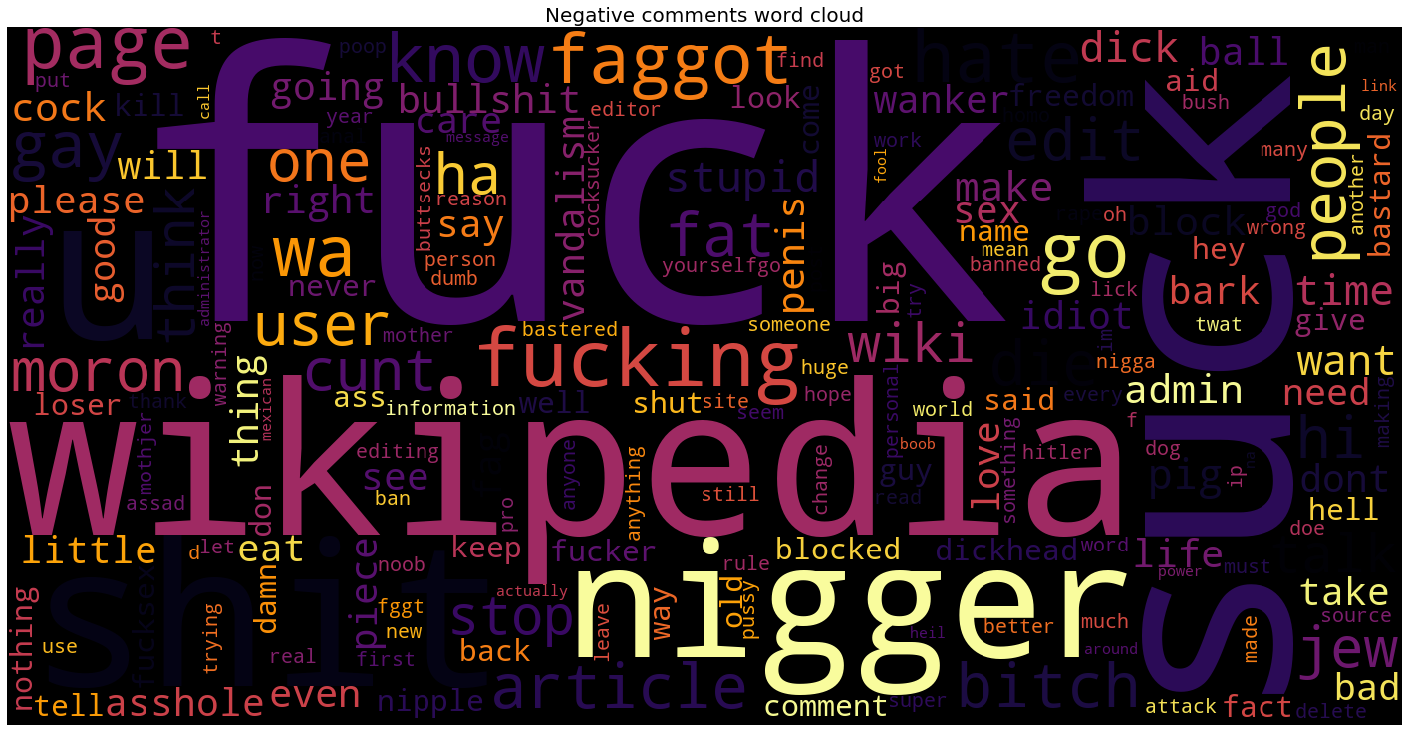

In [11]:
keys = ['Positive', 'Negative']
values = [positive, negative]

for (i, j) in (zip(keys, values)):
    wordcloud = WordCloud(width = 1400, height = 700, collocations=False, colormap='inferno').generate(j)
    plt.figure(figsize = (25,20)) 
    plt.imshow(wordcloud) 
    plt.axis('off') 
    plt.title(f'{i} comments word cloud', fontsize=20)
    plt.show()
    
    

В позитивных комментариях в основном используются нейтральные слова, такие как *article, page, talk, people* или положительные по смыслу: *please, thank*.  

С токсичными комментариями картина другая: в основном они содержат различные оскорбления. Забавно, что очень часто встречается слово *wikipedia*.  

Продолжим работу с данными: нужно вычислить `TF-IDF` для корпуса текстов. Для корректных расчетов разделим выборки на обучающую и тестовую.

In [12]:
X = data['text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
count_tf_idf = TfidfVectorizer() 
X_train_transformed = count_tf_idf.fit_transform(X_train)
X_test_transformed = count_tf_idf.transform(X_test)

Данные преобразованы, теперь можем обучать модели.

## Обучение

<p>
<center><b>Обучение без подбора гиперпараметров</b></center> 
</p>

Будем обучать логистическую регрессию, дерево решений и случайный лес.  

Создадим пустой список, в который будем записывать значения метрики **F1 score**.

In [29]:
scores = []

**Логическая регрессия**

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train_transformed, y_train)
log_reg_pred = log_reg.predict(X_test_transformed) 
log_reg_f1 = f1_score(y_test, log_reg_pred)
scores.append(log_reg_f1)
print(f'Значение F1 меры логистической регрессии: {log_reg_f1:.3f}')

Значение F1 меры логистической регрессии: 0.746


**Решающее дерево**

In [31]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_transformed, y_train)
decision_tree_pred = decision_tree.predict(X_test_transformed) 
decision_tree_f1 = f1_score(y_test, decision_tree_pred)
scores.append(decision_tree_f1)
print(f'Значение F1 меры дерева решений: {decision_tree_f1:.3f}')

Значение F1 меры дерева решений: 0.702


**Случайный лес**

In [32]:
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_train_transformed, y_train)
rand_forest_pred = rand_forest.predict(X_test_transformed) 
rand_forest_f1 = f1_score(y_test, rand_forest_pred)
scores.append(rand_forest_f1)
print(f'Значение F1 меры случайного леса: {rand_forest_f1:.3f}')

Значение F1 меры случайного леса: 0.642


**Результаты без подбора гиперпараметров**

In [33]:
dict_models = {
    'model':['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'],
    'F1_score':[i for i in scores]
    
}
test_scores = pd.DataFrame.from_dict(dict_models)
test_scores.sort_values(by='F1_score', ascending=False)

,model,F1_score
0,LogisticRegression,0.745675
1,DecisionTreeClassifier,0.702444
2,RandomForestClassifier,0.642344


Ни одна модель не удовлетворяет требованиям по качеству. Попробуем подобрать гиперпараметры с помощью `RandomizedSearchCV`  


<p>
<center><b>Подбор гиперпараметров</b></center> 
</p>

**Логистическая регрессия**

In [19]:
train_scores = []

log_reg_params = {'C' : np.logspace(-3,3,7), 'penalty' : ['l1', 'l2']}
log_reg_tune = LogisticRegression()
log_reg_search = RandomizedSearchCV(log_reg_tune, log_reg_params, n_jobs=-1, cv=5, scoring='f1')
log_reg_search.fit(X_train_transformed, y_train)
train_scores.append(log_reg_search.best_score_)

print(f'Лучшая модель: {log_reg_search.best_params_}')
print(f'Лучшая оценка: {log_reg_search.best_score_}')

Лучшая модель: {'penalty': 'l1', 'C': 10.0}
Лучшая оценка: 0.7690977595773254


**Решающее дерево**

In [20]:
decision_tree_params = {
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
decision_tree_tune = DecisionTreeClassifier(random_state=42)
decision_tree_search = RandomizedSearchCV(decision_tree_tune, decision_tree_params, n_jobs=-1, cv=5, scoring='f1')
decision_tree_search.fit(X_train_transformed, y_train)
train_scores.append(decision_tree_search.best_score_)

print(f'Лучшая модель: {decision_tree_search.best_params_}')
print(f'Лучшая оценка: {decision_tree_search.best_score_}')

Лучшая модель: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}
Лучшая оценка: 0.6973889354951066


**Случайный лес**

In [22]:
random_forest_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]
}
random_forest_tune = RandomForestClassifier(random_state=42)
random_forest_search = RandomizedSearchCV(random_forest_tune, random_forest_params, n_jobs=-1, cv=5, scoring='f1')
random_forest_search.fit(X_train_transformed, y_train)
train_scores.append(random_forest_search.best_score_)

print(f'Лучшая модель: {random_forest_search.best_params_}')
print(f'Лучшая оценка: {random_forest_search.best_score_}')

Лучшая модель: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Лучшая оценка: 0.6661125861413659


**Результаты подбора гиперпараметров (на трэйне)**

In [23]:
train_dict_models = {
    'model':['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'],
    'F1_score':[i for i in train_scores]
    
}
tr_scores = pd.DataFrame.from_dict(train_dict_models)
tr_scores.sort_values(by='F1_score', ascending=False)

,model,F1_score
0,LogisticRegression,0.769098
1,DecisionTreeClassifier,0.697389
2,RandomForestClassifier,0.666113


В результате подбора гиперпараметров только логистическая регрессия на обучающей выборке показала достаточно приемлемое качество. Теперь проверим на тесте.

<p>
<center><b>Обучение моделей с оптимальными гиперпараметрами</b></center> 
</p>

**Логистическая регрессия**

In [34]:
final_scores = []

final_log_reg = LogisticRegression(penalty='l1', C=10.0)
final_log_reg.fit(X_train_transformed, y_train)
final_log_reg_pred = final_log_reg.predict(X_test_transformed) 
final_log_reg_f1 = f1_score(y_test, final_log_reg_pred)
final_scores.append(final_log_reg_f1)
print(f'Значение F1 меры логистической регрессии: {final_log_reg_f1:.3f}')

Значение F1 меры логистической регрессии: 0.779


**Решающее дерево**

In [35]:
final_decision_tree = DecisionTreeClassifier(
    random_state=42, 
    min_samples_split=5, 
    min_samples_leaf=4, 
    max_depth=None, 
    criterion='gini'
)

final_decision_tree.fit(X_train_transformed, y_train)
final_decision_tree_pred = final_decision_tree.predict(X_test_transformed) 
final_decision_tree_f1 = f1_score(y_test, final_decision_tree_pred)
final_scores.append(final_decision_tree_f1)
print(f'Значение F1 меры дерева решений: {final_decision_tree_f1:.3f}')

Значение F1 меры дерева решений: 0.708


**Случайный лес**

In [38]:
final_rand_forest = RandomForestClassifier(n_estimators=200, 
                                           min_samples_split=10, 
                                           min_samples_leaf=1,
                                           max_features='auto', 
                                           max_depth=None, 
                                           bootstrap=True,
                                           random_state=42)
final_rand_forest.fit(X_train_transformed, y_train)
final_rand_forest_pred = final_rand_forest.predict(X_test_transformed) 
final_rand_forest_f1 = f1_score(y_test, final_rand_forest_pred)
final_scores.append(final_rand_forest_f1)
print(f'Значение F1 меры случайного леса: {final_rand_forest_f1:.3f}')

Значение F1 меры случайного леса: 0.683


**Финальные результаты**

In [39]:
final_dict_models = {
    'model':['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'],
    'F1_score':[i for i in final_scores]
    
}
final_scores = pd.DataFrame.from_dict(final_dict_models)
final_scores.sort_values(by='F1_score', ascending=False)

,model,F1_score
0,LogisticRegression,0.778674
1,DecisionTreeClassifier,0.708244
2,RandomForestClassifier,0.682734


Лучший результат на тестовой выборке показала **Логистическая регрессия** со значением **F1-меры 0.779**.

**Проверка модели на адекватность**  

Проверим модель на адекватность с помощью **DummyClassifier** из библиотеки `scikit-learn`:

In [43]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train_transformed, y_train)
dummy_pred = dummy_model.predict(X_test_transformed)
dummy_f1 = f1_score(y_test, dummy_pred)
print(f'Значение F1 меры DummyClassifier: {dummy_f1:.3f}')

Значение F1 меры DummyClassifier: 0.103


## Выводы

1. В токсичных комментариях в основном содержатся прямые оскорбления, и, как ни странно, очень часто встречается слово *wikipedia*;
2. К сожалению, грамотная лемматизация оказалась непосильной задачей как для библиотеки `nltk`, так и для `pymystem3`;
3. Лучше всего с задачей классификации справилась логистическая регрессия со значением **F1-меры 0.779**.